In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dropout, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Accuracy,MeanSquaredError 


print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.3.0


In [ ]:
def create_model(input_shape, pool_size):
    # Create the actual neural network here
    model = Sequential()
    # Normalizes incoming inputs. First layer needs the input shape to work
    model.add(BatchNormalization(input_shape=input_shape))

    # Below layers were re-named for easier reading of model summary; this not necessary
    # Conv Layer 1
    model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'))

    # Conv Layer 2
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))

    # Pooling 1
    model.add(MaxPooling2D(pool_size=pool_size))

    # Conv Layer 3
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
    model.add(Dropout(0.2))

    # Conv Layer 4
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'))
    model.add(Dropout(0.2))

    # Conv Layer 5
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'))
    model.add(Dropout(0.2))

    # Pooling 2
    model.add(MaxPooling2D(pool_size=pool_size))

    # Conv Layer 6
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'))
    model.add(Dropout(0.2))

    # Conv Layer 7
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'))
    model.add(Dropout(0.2))

    # Pooling 3
    model.add(MaxPooling2D(pool_size=pool_size))

    # Upsample 1
    model.add(UpSampling2D(size=pool_size))

    # Deconv 1
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
    model.add(Dropout(0.2))

    # Deconv 2
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))
    model.add(Dropout(0.2))

    # Upsample 2
    model.add(UpSampling2D(size=pool_size))

    # Deconv 3
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'))
    model.add(Dropout(0.2))

    # Deconv 4
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'))
    model.add(Dropout(0.2))

    # Deconv 5
    model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'))
    model.add(Dropout(0.2))

    # Upsample 3
    model.add(UpSampling2D(size=pool_size))

    # Deconv 6
    model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'))

    # Final layer - only including one channel so 1 filter
    model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))

    return model

In [ ]:
# Load training images
train_images = pickle.load(open("/content/drive/My Drive/Ego-Lane-Detection-on-CARLA/images.pkl", "rb" ))

# Load image labels
labels = pickle.load(open("/content/drive/My Drive/Ego-Lane-Detection-on-CARLA/labels.pkl", "rb" ))

# Make into arrays as the neural network wants these
train_images = np.array(train_images)
labels = np.array(labels)

(13088, 80, 160, 3)
(13088, 80, 160, 1)


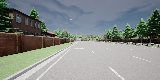

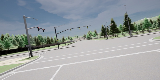

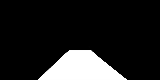

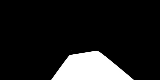

In [ ]:
print(train_images.shape)
print(labels.shape)
cv2_imshow(train_images[0])
cv2_imshow(train_images[-1])
cv2_imshow(labels[0])
cv2_imshow(labels[-1])

In [ ]:
# Normalize labels - training images get normalized to start in the network
#labels = labels / 255

# Shuffle images along with their labels, then split into training/validation sets
train_images, labels = shuffle(train_images, labels)
# Test size may be 10% or 20%
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.15)

# Batch size, epochs and pool size below are all paramaters to fiddle with for optimization
batch_size = 131
epochs = 10
pool_size = (2, 2)
input_shape = X_train.shape[1:]

# Create the neural network
model = create_model(input_shape, pool_size)

# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

# Compiling and training the model
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=[
        MeanSquaredError(),
        Accuracy(),
    ])
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

# Freeze layers since training is done
model.trainable = False
model.compile(optimizer='Adam', loss='mean_squared_error',metrics=[
        MeanSquaredError(),
        Accuracy(),
    ])

# Save model architecture and weights
model.save('/content/drive/My Drive/Ego-Lane-Detection-on-CARLA/full_CNN_model.h5')

# Show summary of model
model.summary()

Epoch 1/10
85/84 [==============================] - 703s 8s/step - loss: 3527.8113 - mean_squared_error: 3527.8115 - accuracy: 0.0162 - val_loss: 9345.1846 - val_mean_squared_error: 9345.1846 - val_accuracy: 1.8899e-04
Epoch 2/10
85/84 [==============================] - 703s 8s/step - loss: 1984.8982 - mean_squared_error: 1984.8979 - accuracy: 0.0045 - val_loss: 2265.7207 - val_mean_squared_error: 2265.7205 - val_accuracy: 0.0175
Epoch 3/10
85/84 [==============================] - 703s 8s/step - loss: 1537.6066 - mean_squared_error: 1537.6066 - accuracy: 0.5980 - val_loss: 2261.3438 - val_mean_squared_error: 2261.3440 - val_accuracy: 0.7337
Epoch 4/10
85/84 [==============================] - 701s 8s/step - loss: 1056.8821 - mean_squared_error: 1056.8821 - accuracy: 0.8046 - val_loss: 3602.7024 - val_mean_squared_error: 3602.7021 - val_accuracy: 0.8400
Epoch 5/10
85/84 [==============================] - 702s 8s/step - loss: 916.0937 - mean_squared_error: 916.0937 - accuracy: 0.8267 - va

In [ ]:
new_labels = labels

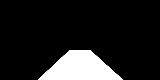

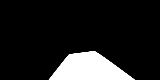

In [ ]:
cv2_imshow(new_labels[0])
cv2_imshow(new_labels[-1])

(1, 80, 160, 3)
(1, 80, 160, 1)
(80, 160, 1)


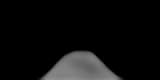

In [ ]:
img = train_images[0]
img = np.array(img)
img = img[None,:,:,:]
print(img.shape)
p = model.predict(img)
print(p.shape)
p_new = p[-1,:,:]
print(p_new.shape)
cv2_imshow(p_new)

In [ ]:
with open('/content/drive/My Drive/Ego-Lane-Detection-on-CARLA/model_history', 'wb') as file_history:
        pickle.dump(history.history, file_history)

In [ ]:
with open('/content/drive/My Drive/Ego-Lane-Detection-on-CARLA/model_history', 'rb') as f:
    # load using pickle de-serializer
    history = pickle.load(f)

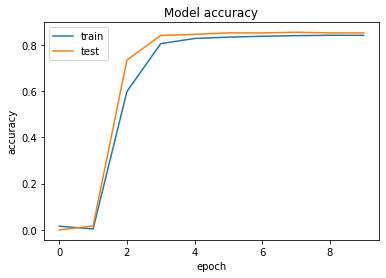

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/drive/My Drive/Ego-Lane-Detection-on-CARLA/acurracy.png')
plt.show()

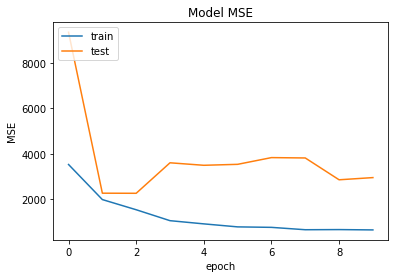

In [ ]:
plt.plot(history['mean_squared_error'])
plt.plot(history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/drive/My Drive/Ego-Lane-Detection-on-CARLA/MSE_or_Loss.png')
plt.show()

In [ ]:
print(history['accuracy'][-1],history['val_accuracy'][-1])

0.8402789235115051 0.8507924675941467


In [ ]:
print(history['mean_squared_error'][-1],history['val_mean_squared_error'][-1])

650.263916015625 2951.640625
